"예측 분석과 해석" 과제 레포트를 다음과 같은 순서로 작성합니다.



1. 문제 정의
2. 데이터 탐색 및 전처리
3. 예측 분석 ==> 회귀 예측/분류예측 모두 가능합니다.
    :본인이 적용할 수 있는 알고리즘을 적용하여 최적의 모델과 이때의 성능 평가 결과를 제시
4. 테스트 데이터로 예측한 결과 군집화 ==> K-Means 알고리즘 적용
    :실루엣 계수를 이용한 적절한 K 선정 및 PCA로 군집 결과 시각화
5. 결과 해석

In [208]:
pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
!pip3 install KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for KMeans: filename=kmeans-1.0.2-cp310-cp310-linux_x86_64.whl size=12565 sha256=035d7f577c73bf609cecf918f937e0e160945b8bdd4a594e2b80038215d7799c
  Stored in directory: /root/.cache/pip/wheels/46/bb/83/beb390fc9fcc845a65a82eb476fc1697e9b8ab5fb795beb220
Successfully built KMeans


In [212]:
import sklearn
print(sklearn.__version__)

1.2.2


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
train = pd.read_csv('/content/drive/MyDrive/데이터시각화01/assignment/data/wine_train.csv')
test = pd.read_csv('/content/drive/MyDrive/데이터시각화01/assignment/data/wine_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/데이터시각화01/assignment/data/wine_sample_submission.csv')

# **데이터 탐색**

In [49]:
train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


In [50]:
test.head()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,white
1,1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,red
2,2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,white
3,3,7.2,0.15,0.39,1.8,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,white
4,4,6.8,0.26,0.26,2.0,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,white


품질을 예측하는 것이므로, wine_train에는 quality변수가 있지만, wine_test에는 quality 변수가 없다.

In [51]:
train.isna().sum()

index                   0
quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64

결측치를 확인한다. 결측치가 없다.

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5497 entries, 0 to 5496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5497 non-null   int64  
 1   quality               5497 non-null   int64  
 2   fixed acidity         5497 non-null   float64
 3   volatile acidity      5497 non-null   float64
 4   citric acid           5497 non-null   float64
 5   residual sugar        5497 non-null   float64
 6   chlorides             5497 non-null   float64
 7   free sulfur dioxide   5497 non-null   float64
 8   total sulfur dioxide  5497 non-null   float64
 9   density               5497 non-null   float64
 10  pH                    5497 non-null   float64
 11  sulphates             5497 non-null   float64
 12  alcohol               5497 non-null   float64
 13  type                  5497 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 601.4+ KB


type이 object인 것을 제외하면 모두 수치형 (int, float) 데이터. 하지만 대부분의 모델에서는 수치형 데이터만을 입력으로 받을 수 있음. 따라서 type의 값을 수치형으로 바꿔줘야함. 그러면 지금 type에는 무엇이 담겨져 있는 걸까?

In [53]:
set(train['type'].values)

{'red', 'white'}

{'red', 'white'} 즉, red와인과 white와인 type이 들어가있다.

In [54]:
set(train['quality'].values)

{3, 4, 5, 6, 7, 8, 9}

quality는 3점부터 9점까지 존재.


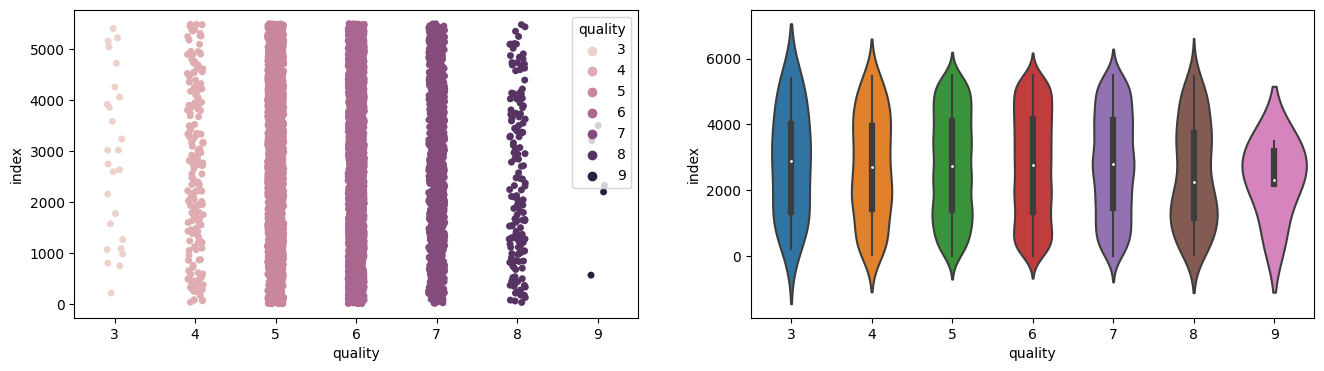

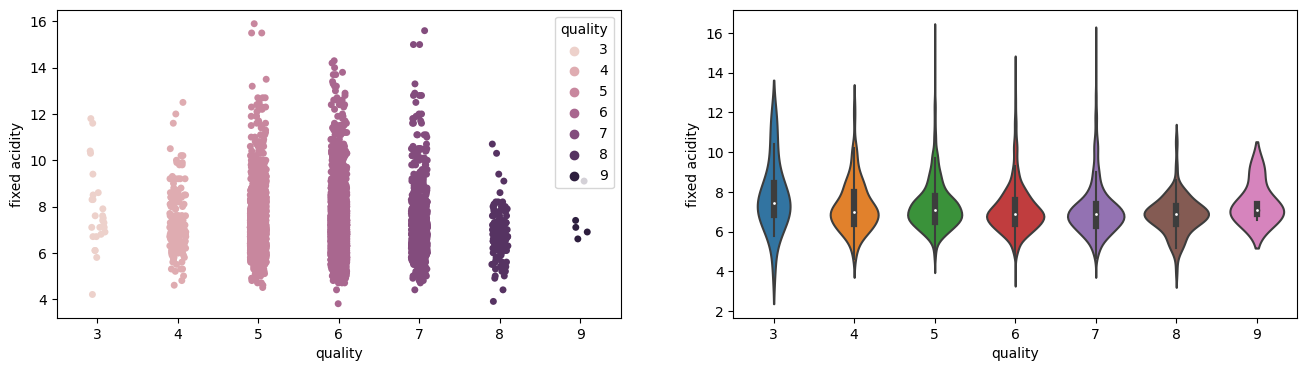

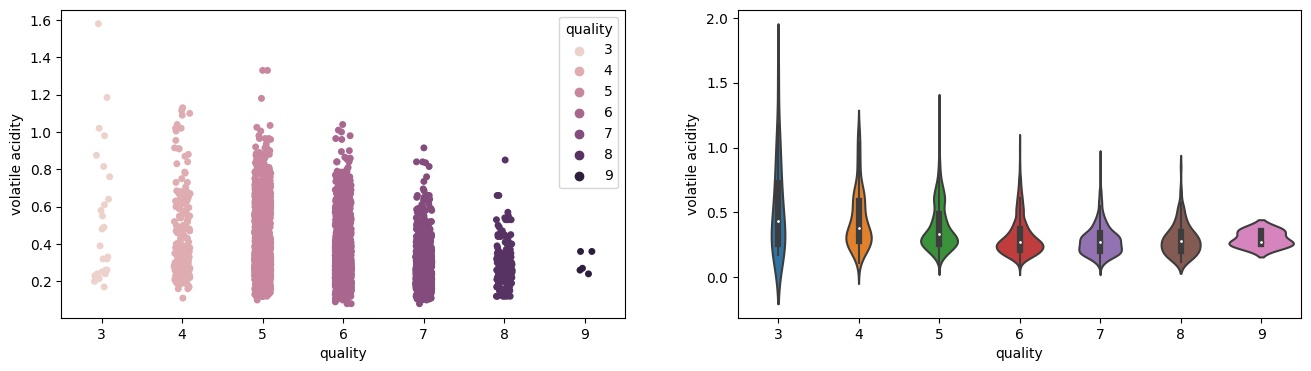

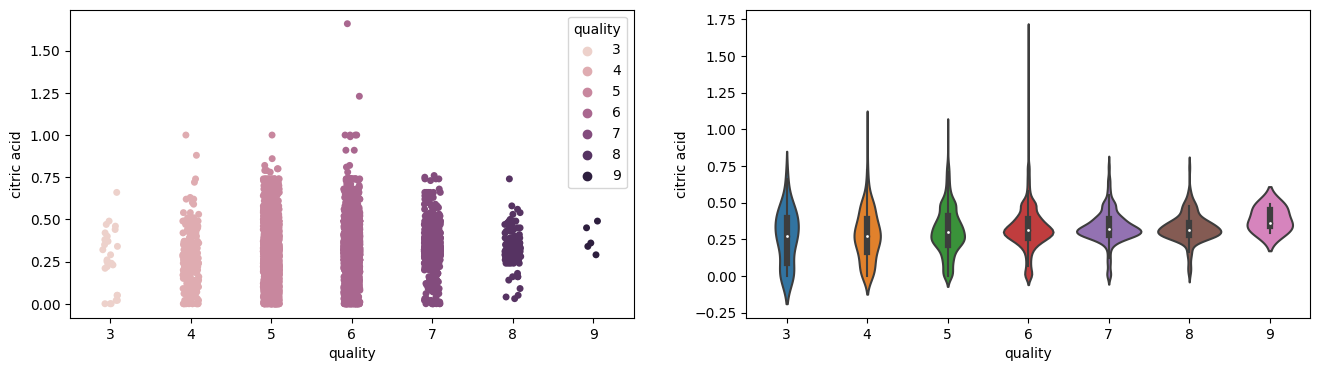

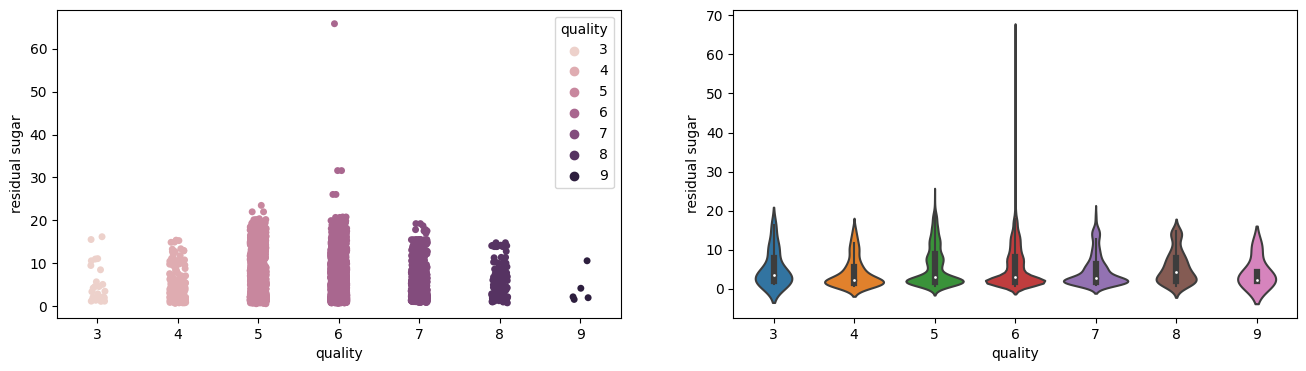

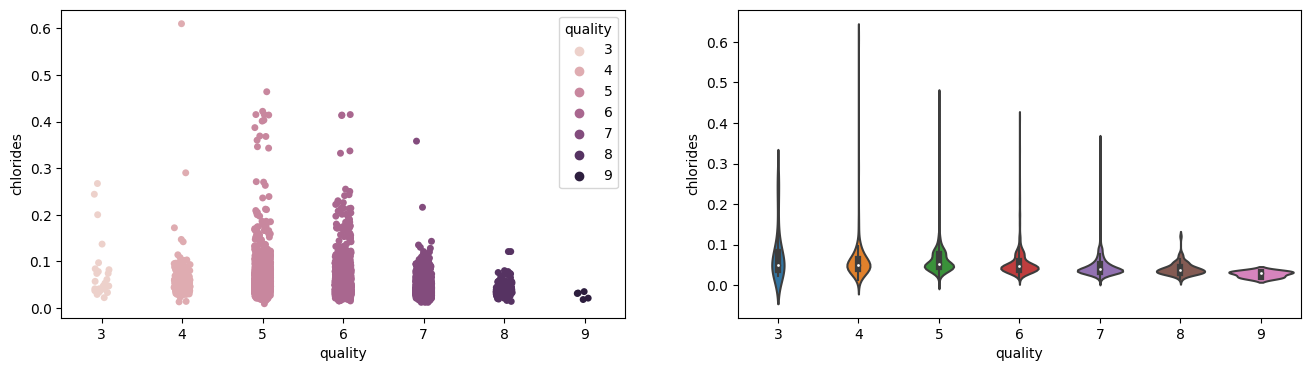

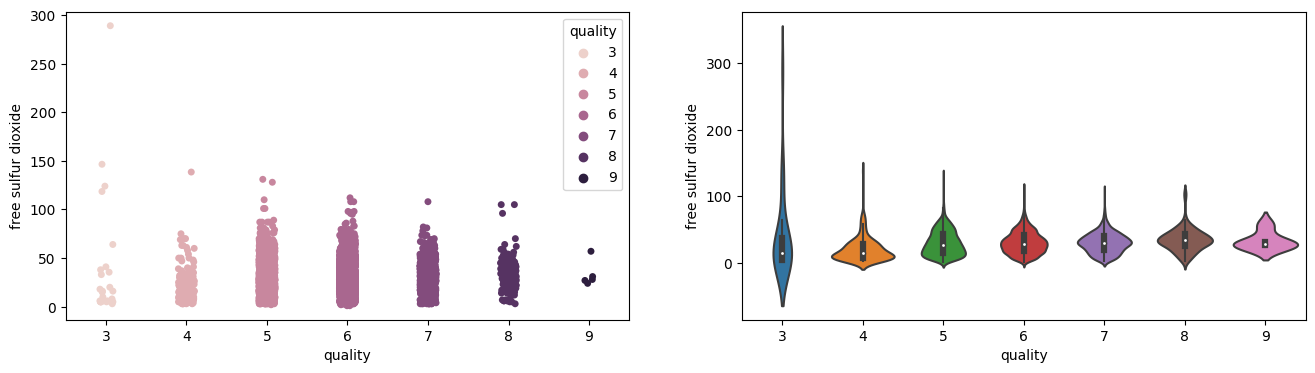

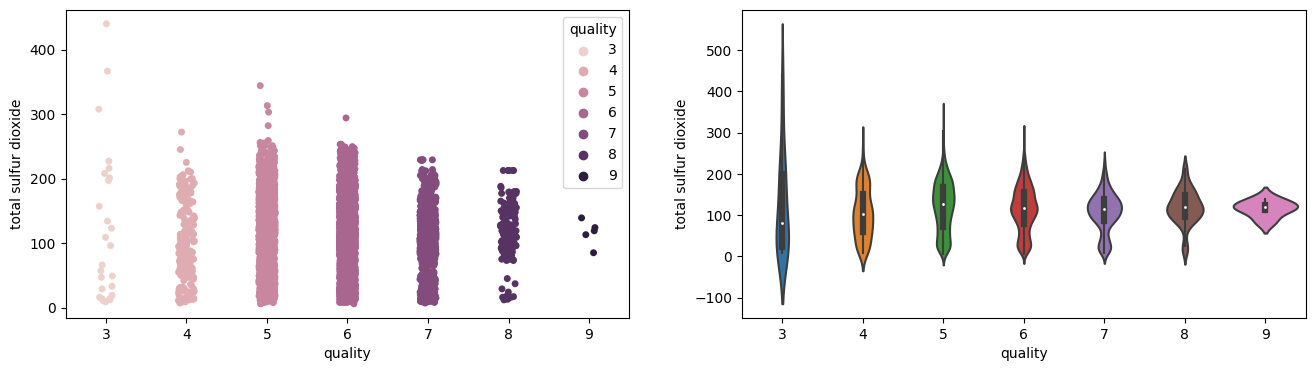

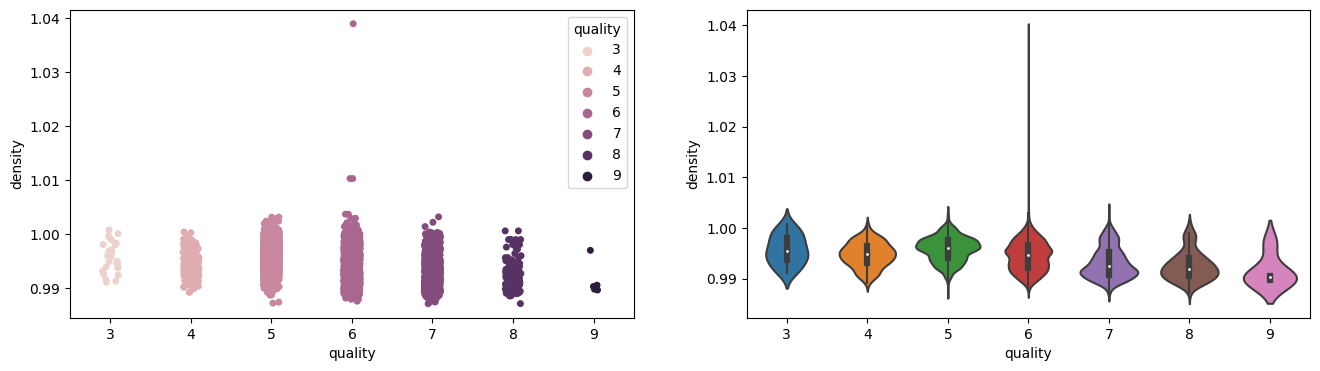

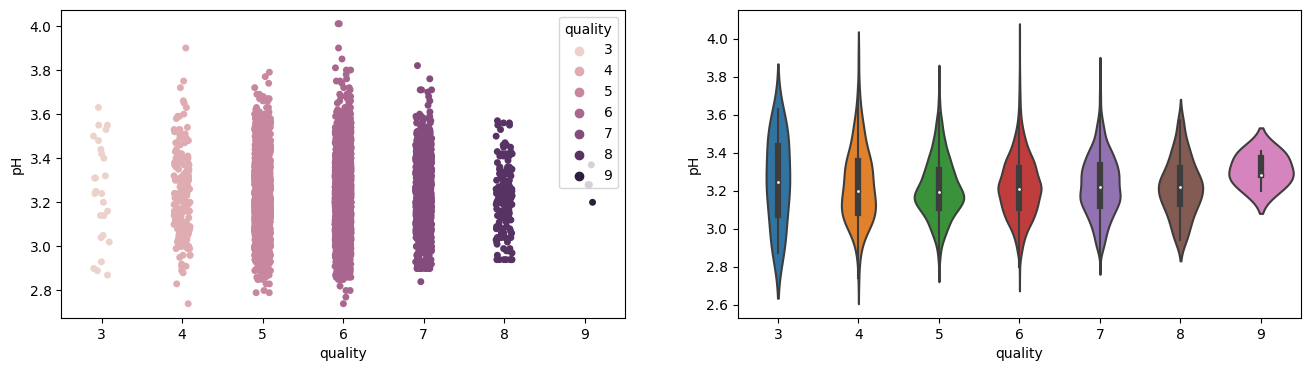

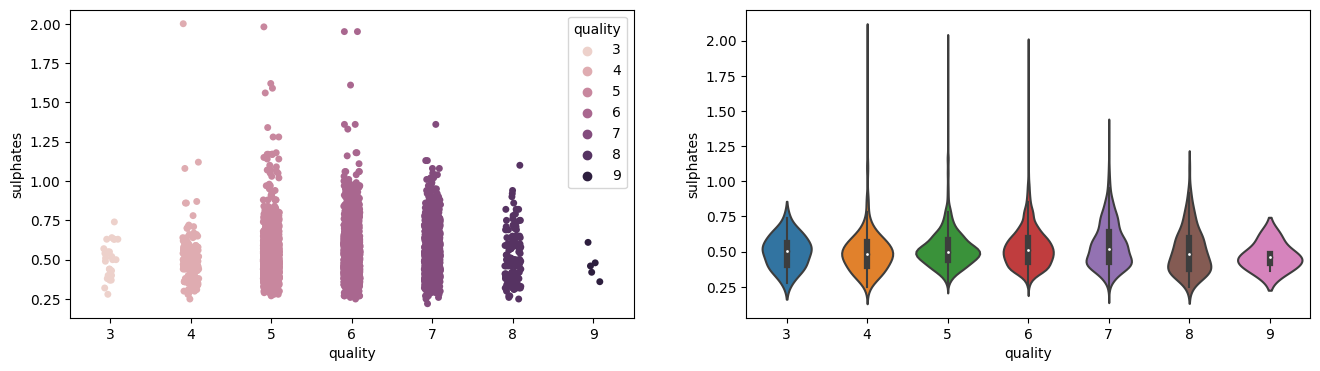

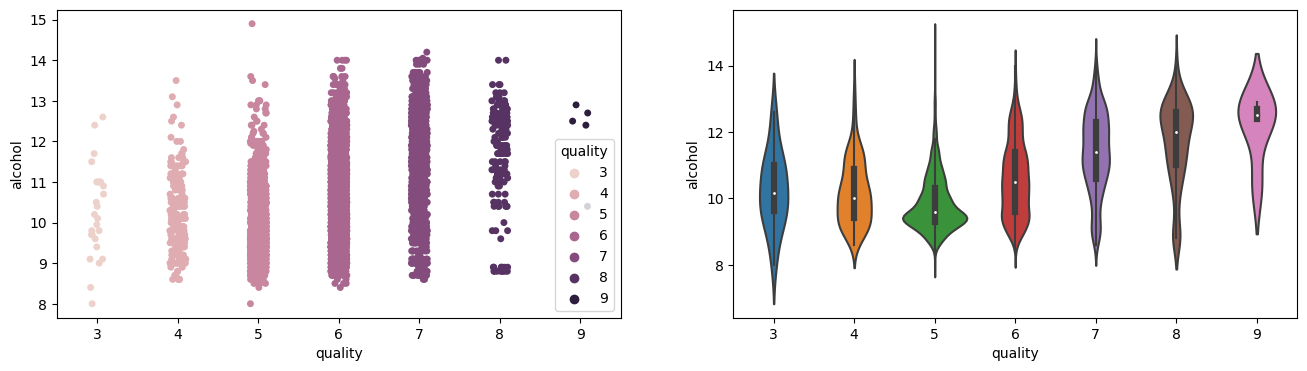

In [59]:
quality = train.select_dtypes(exclude='object').columns.tolist()
quality.remove('quality')

def show_dist_plot(df, columns):
    for column in columns:
        f, ax = plt.subplots(1,2,figsize=(16,4))
        sns.stripplot(x=df['quality'],y=df[column], ax=ax[0],hue=df['quality'])
        sns.violinplot(data=df, x='quality', y=column, ax=ax[1])

show_dist_plot(train, quality)

각 변수별로 quality의 분포가 어떻게 되는지 시각화하여 확인. 하지만 보기 어려움. 따라서 heatmap으로 상관관계 파악.

<Axes: >

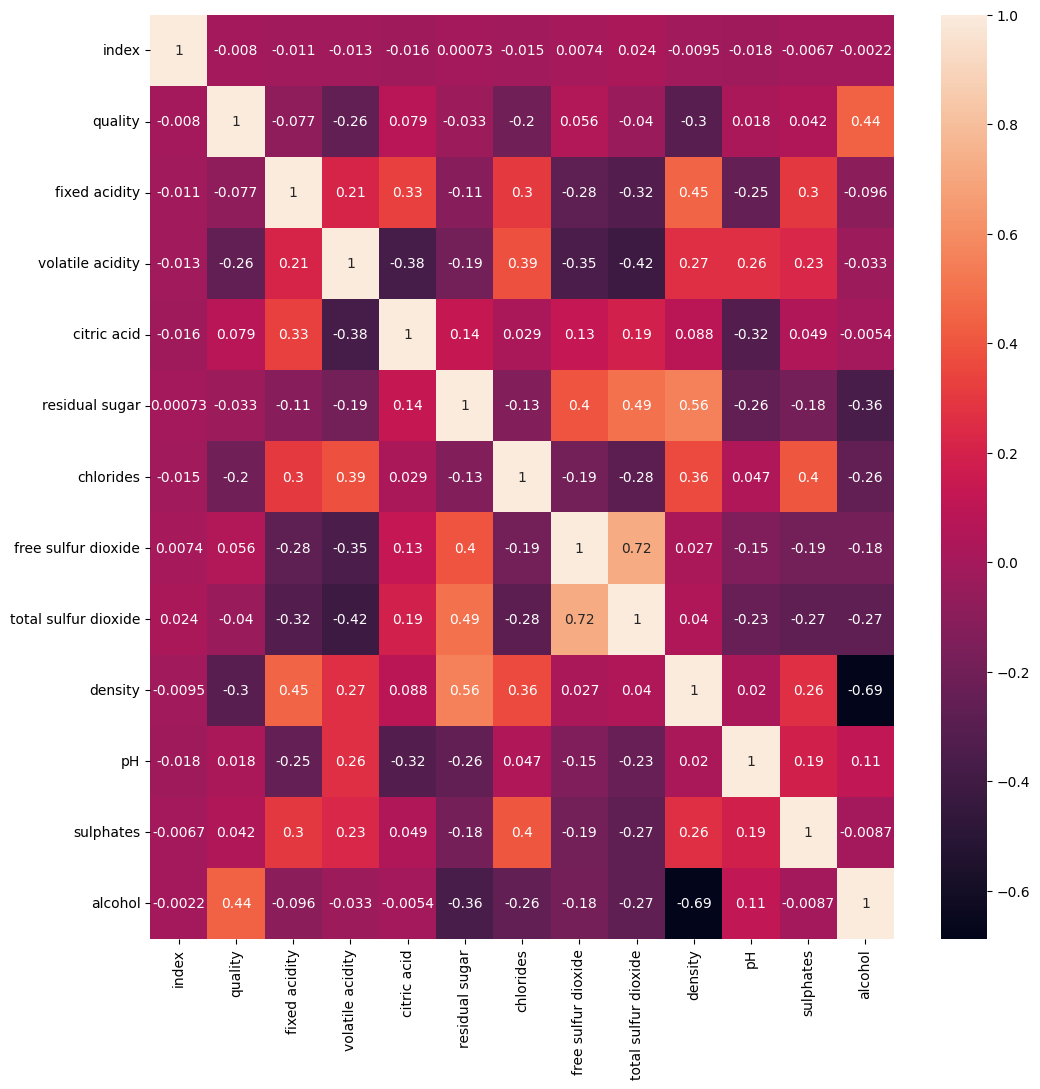

In [55]:
plt.figure(figsize=(12,12))
sns.heatmap(data = train.corr(), annot=True)

train data의 변수간 상관관계를 확인한다. 와인 품질을 예측하려고한다. 따라서 quality변수를 주목해서 봐야한다.하지만 quality변수(target변수)와 상관관계가 존재하는 변수가 거의 없다.(0보다 작으면 음의 상관관계라고하며, 0에 가까울수록 두 변수 사이에는 상관관계가 존재하지 않는다고 말한다.) 따라서 선형회귀는 적합하지 않음. (선형회귀는 변수들이 서로 선형적으로 연결되어 있는 경우 사용하기 때문)

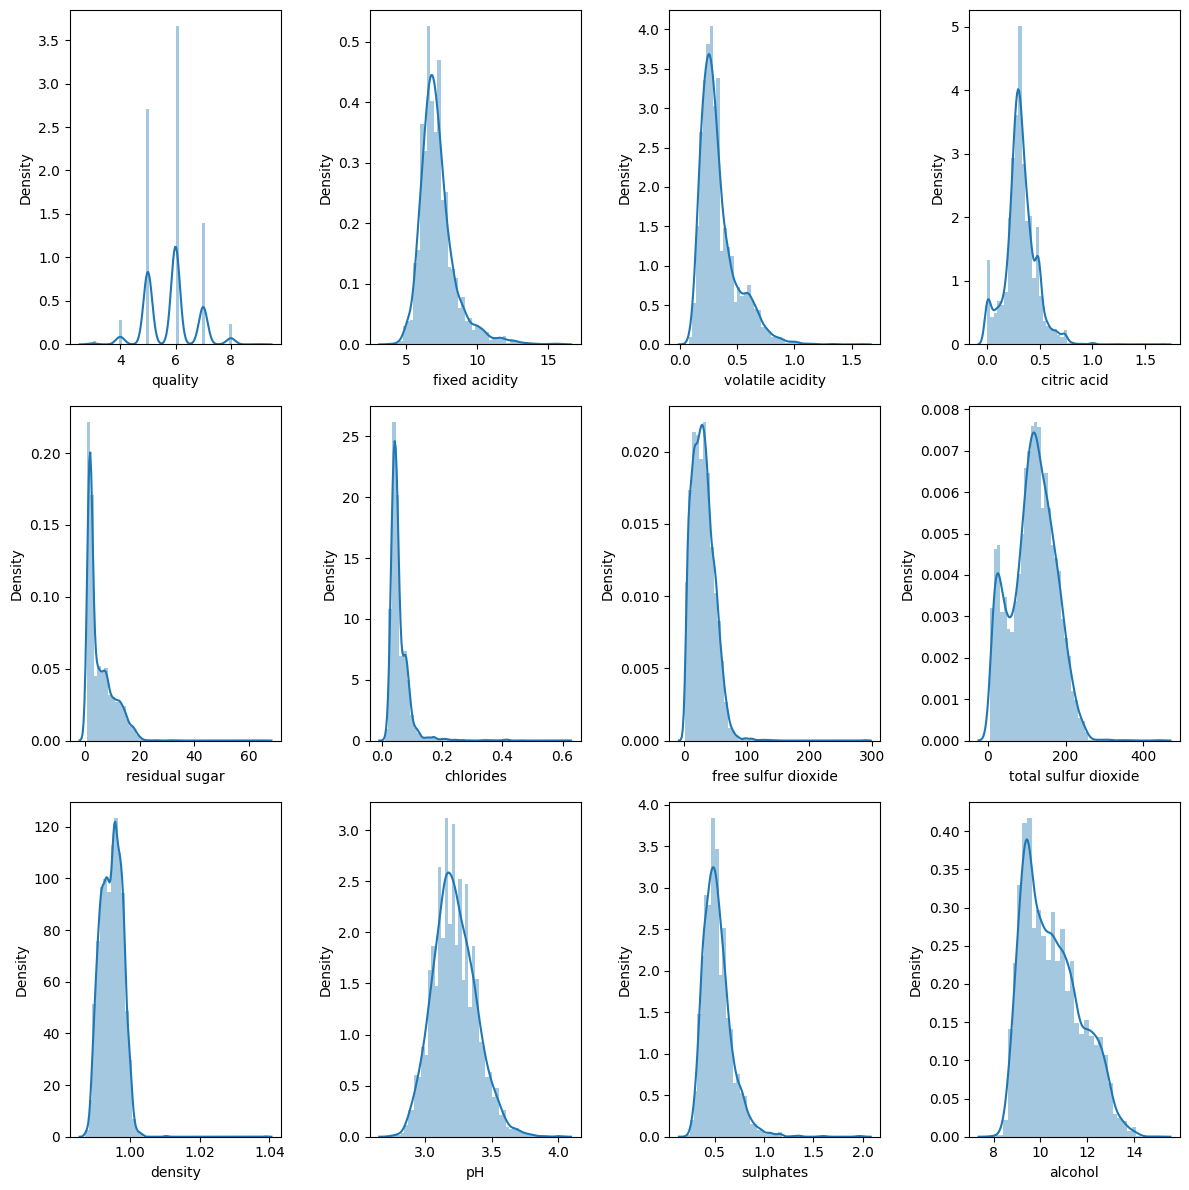

In [56]:
# train 각 변수의 분포 확인
plt.figure(figsize=(12,12))
for i in range(1,13):
    plt.subplot(3,4,i)
    sns.distplot(train.iloc[:,i])
plt.tight_layout()
plt.show()

각 변수들의 분포를 살펴보았다. 살펴보니, 변수들의 값의 범위(scale)이  같지 않은 것을 확인할 수 있다.


따라서
1.   StandScaler로 표준화 작업 진행
2.   type을 0과 1로 맞춰주기



In [76]:
# sk learn model 일단 다 부르기
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn import metrics

In [65]:
# 데이터 표준화
sc = StandardScaler()
train[quality] = sc.fit_transform(train[quality])
test[quality] = sc.fit_transform(test[quality])

#factorize
train['type'] = pd.factorize(train['type'])[0]
test['type'] = pd.factorize(test['type'])[0]

train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,-1.731736,5,-1.250611,2.186377,-1.781940,0.286345,-0.398500,-1.211937,-0.560852,-0.117252,1.372128,-0.605988,-0.255287,0
1,-1.731106,5,1.234899,1.665574,-1.230560,-0.638755,0.322998,-1.155351,-1.307080,0.738864,-0.183584,0.398147,-0.841348,1
2,-1.730475,5,0.535849,-0.785265,0.492500,-0.722855,0.034399,-0.532907,0.398583,-0.966732,-1.054782,-0.070450,0.330774,0
3,-1.729845,6,-0.163201,-0.785265,-0.058879,0.118145,-0.283060,-0.080221,-0.134436,-0.256620,0.252016,-0.204334,0.247051,0
4,-1.729215,6,0.458177,0.378883,-0.403491,0.854020,0.092119,0.089537,1.109276,0.274305,-1.117010,-0.672931,0.330774,0




1.   StandardScaler()로 표준화 진행하였음
2.   white : 0, red :1 로 맞춰줌



In [66]:
test.head()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,-1.730320,1.306951,-0.220579,1.098184,0.236865,-0.385503,-1.108531,-0.756734,-0.352060,-1.943080,-1.068114,1.000172,0
1,-1.726856,4.507070,0.477272,1.780836,-0.749722,0.343645,-0.888114,-1.327873,1.915724,-0.949812,-0.311854,-1.203025,1
2,-1.723391,-0.553583,-0.395042,-0.335387,-0.057012,-0.466520,0.709907,1.077835,-0.008456,-0.142782,1.063164,-0.864071,0
3,-1.719927,-0.032634,-1.151046,0.483796,-0.770714,-0.385503,-0.557489,0.731690,-0.008456,1.905833,-0.449356,-0.355641,0
4,-1.716463,-0.330319,-0.511350,-0.403653,-0.728731,-1.033635,-0.419728,-0.774041,-1.516876,-0.329020,-0.449356,1.169649,0


test data에도 맞추어져 있다는 것을 확인할 수 있음

In [69]:
print(train['quality'].value_counts()) #데이터 셋 확인

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64


# **예측분석**

In [112]:
## 종속변수와 독립변수를 나누어주는 작업

x_train = train.drop(['quality'], axis=1)
y_train = train.quality
x_test = test

print(len(train), len(test))

5497 1000


In [115]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train.shape, x_test.shape

((2813, 13), (704, 13))

ⓐ 아래는 Random Forest

In [226]:
## 모델의 선언
rfc = RandomForestClassifier(n_estimators = 500)

## 학습데이터의 모델 적용
rfc.fit(x_train, y_train)

## 모델의 예측값 산출
pred_rfc = rfc.predict(x_test)

## 다양한 모델 평가 : y_test
print(classification_report(y_test, pred_rfc))

print("y_test Accuracy : ", metrics.accuracy_score(y_test, pred_rfc))

print("Precision Score : ", metrics.precision_score(y_test, pred_rfc,
                                           pos_label='positive',
                                           average='macro'))

print("Recall Score    : ", metrics.recall_score(y_test, pred_rfc,
                                           pos_label='positive',
                                           average='macro'))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.06      0.12        31
           5       0.68      0.66      0.67       224
           6       0.63      0.79      0.70       319
           7       0.65      0.50      0.56       105
           8       0.75      0.26      0.39        23

    accuracy                           0.65       704
   macro avg       0.62      0.38      0.41       704
weighted avg       0.67      0.65      0.63       704

y_test Accuracy :  0.6519886363636364
Precision Score :  0.6187895777345319
Recall Score    :  0.37802865516690054


HyperParameter 튜닝 진행

In [179]:
model = RandomForestClassifier()
params={'n_estimators':[50,100,150,200,400,500],'max_features':[0.2,0.4,0.6,0.8,1.0]}
gridsearch=GridSearchCV(model,params,cv=5)
gridsearch.fit(x_train,y_train)
gridsearch.best_params_

{'max_features': 0.2, 'n_estimators': 150}

...? hyperParameter Tuning 안한게 accuracy가 더 높음..

In [234]:
model = RandomForestClassifier(max_features = 0.2, n_estimators = 200)
## 학습데이터의 모델 적용
model.fit(x_train, y_train)

## 모델의 예측값 산출
pred_model = model.predict(x_test)

## 다양한 모델 평가 : y_test
print(classification_report(y_test, pred_model))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.06      0.12        31
           5       0.70      0.66      0.68       224
           6       0.64      0.80      0.71       319
           7       0.68      0.51      0.59       105
           8       0.75      0.26      0.39        23

    accuracy                           0.66       704
   macro avg       0.63      0.38      0.41       704
weighted avg       0.68      0.66      0.64       704



ⓑ 아래는 SVM

1. svm - linear

In [161]:
# SVM 모델 생성
svc = svm.SVC(kernel='linear', C=1.0, random_state=42) #linear 쓰고 싶으면 linear로. 만약 가우스 쓰고 싶으면 가우스로 변경

# 모델 훈련
svc.fit(x_train, y_train)

# 예측
y_pred = svc.predict(x_test)

In [162]:
# 성능 평가
print(classification_report(y_test, y_pred)) # (정답, 예측값)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        31
           5       0.62      0.62      0.62       224
           6       0.54      0.82      0.65       319
           7       0.00      0.00      0.00       105
           8       0.00      0.00      0.00        23

    accuracy                           0.57       704
   macro avg       0.19      0.24      0.21       704
weighted avg       0.44      0.57      0.49       704



2. linear - rbf

In [163]:
# SVM 모델 생성
svc = svm.SVC(kernel='rbf', C=1.0, random_state=42)
# to 비선형 모델로 바꾸기 위해서 rbf 사용.

# 모델 훈련
svc.fit(x_train, y_train)

# 예측
y_pred = svc.predict(x_test)

In [164]:
# 성능 평가
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        31
           5       0.64      0.62      0.63       224
           6       0.59      0.80      0.68       319
           7       0.56      0.31      0.40       105
           8       0.00      0.00      0.00        23

    accuracy                           0.60       704
   macro avg       0.30      0.29      0.28       704
weighted avg       0.56      0.60      0.57       704



ⓒ 아래는 로지스틱 회귀 모델 생성

In [165]:
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 생성
logisticR = LogisticRegression(random_state=42)

# 모델 훈련
logisticR.fit(x_train, y_train)

# 예측
y_pred = logisticR.predict(x_test)

In [167]:
# 성능 평가
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       1.00      0.50      0.67         2
           4       0.33      0.03      0.06        31
           5       0.62      0.62      0.62       224
           6       0.57      0.73      0.64       319
           7       0.47      0.32      0.38       105
           8       0.00      0.00      0.00        23

    accuracy                           0.58       704
   macro avg       0.50      0.37      0.39       704
weighted avg       0.54      0.58      0.55       704



ⓓ 아래는 Decision Tree 모델

In [195]:
# decision tree 모델 생성
decisionT = tree.DecisionTreeClassifier(random_state=42)

# 모델 훈련
decisionT.fit(x_train, y_train)

# 예측
y_pred = decisionT.predict(x_test)

In [196]:
print(classification_report(y_test, y_pred))

print("y_test Accuracy : ", metrics.accuracy_score(y_test, y_pred))

print("Precision Score : ", metrics.precision_score(y_test, y_pred,
                                           pos_label='positive',
                                           average='macro'))

print("Recall Score    : ", metrics.recall_score(y_test, y_pred,
                                           pos_label='positive',
                                           average='macro'))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.13      0.13      0.13        31
           5       0.57      0.56      0.56       224
           6       0.61      0.61      0.61       319
           7       0.39      0.40      0.39       105
           8       0.26      0.26      0.26        23
           9       0.00      0.00      0.00         0

    accuracy                           0.53       704
   macro avg       0.28      0.28      0.28       704
weighted avg       0.53      0.53      0.53       704

y_test Accuracy :  0.5284090909090909
Precision Score :  0.27999827337511435
Recall Score    :  0.27988897200361457


ⓔ 아래는 knn 모델

In [197]:
knn_model = KNeighborsClassifier(5)
knn_model.fit(x_train, y_train)
knn_pred = knn_model.predict(x_test)

In [199]:
print(classification_report(y_test, knn_pred))

print("y_test Accuracy : ", metrics.accuracy_score(y_test, y_pred))

print("Precision Score : ", metrics.precision_score(y_test, y_pred,
                                           pos_label='positive',
                                           average='macro'))

print("Recall Score    : ", metrics.recall_score(y_test, y_pred,
                                           pos_label='positive',
                                           average='macro'))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.60      0.10      0.17        31
           5       0.56      0.63      0.59       224
           6       0.57      0.58      0.57       319
           7       0.40      0.44      0.42       105
           8       0.14      0.04      0.07        23

    accuracy                           0.53       704
   macro avg       0.38      0.30      0.30       704
weighted avg       0.53      0.53      0.52       704

y_test Accuracy :  0.5284090909090909
Precision Score :  0.27999827337511435
Recall Score    :  0.27988897200361457


따라서 ⓐ~ⓔ 까지 비교한 결과 rfc_withTuning한 model이 accuracy 0.66으로 가장 높다.

In [244]:
from sklearn.metrics import ConfusionMatrixDisplay

def Model(model):
    model.fit(x_train,y_train)
    score = model.score(x_test,y_test)
    model_train_score= model.score(x_train,y_train)
    model_test_score=model.score(x_test,y_test)
    prediction = model.predict(x_test)
    cm = confusion_matrix(y_test, prediction, labels=model.classes_)
    print("Testing Score\n", score)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

Testing Score
 0.6619318181818182


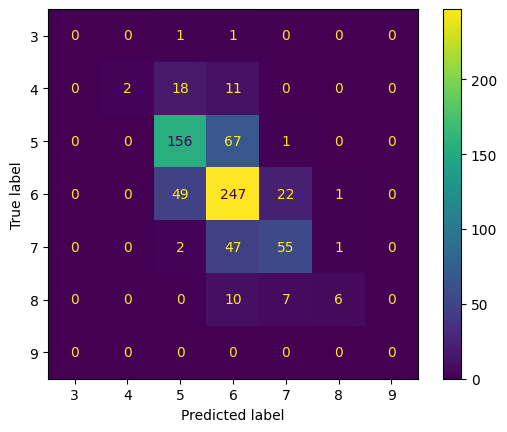

In [245]:
#RandomForest with HyperTuning

model = RandomForestClassifier(max_features = 0.2, n_estimators = 200)
model.fit(x_train, y_train)

Model(model)

In [248]:
predict=model.predict(x_test)

Testing Score
 0.6519886363636364


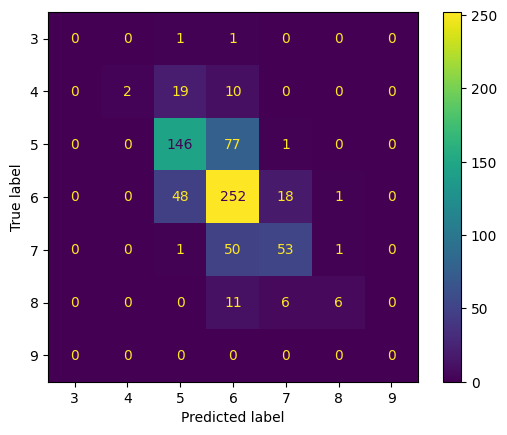

In [246]:
#RandomForest with HyperTuning

model2 = RandomForestClassifier(max_features = 0.2, n_estimators = 200)
model2.fit(x_test, y_test)

Model(model2)

# **테스트 데이터로 예측한 결과 군집화 ==> K-Means 알고리즘 적용**

In [268]:
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,1.306951,-0.220579,1.098184,0.236865,-0.385503,-1.108531,-0.756734,-0.352060,-1.943080,-1.068114,1.000172,0
1,4.507070,0.477272,1.780836,-0.749722,0.343645,-0.888114,-1.327873,1.915724,-0.949812,-0.311854,-1.203025,1
2,-0.553583,-0.395042,-0.335387,-0.057012,-0.466520,0.709907,1.077835,-0.008456,-0.142782,1.063164,-0.864071,0
3,-0.032634,-1.151046,0.483796,-0.770714,-0.385503,-0.557489,0.731690,-0.008456,1.905833,-0.449356,-0.355641,0
4,-0.330319,-0.511350,-0.403653,-0.728731,-1.033635,-0.419728,-0.774041,-1.516876,-0.329020,-0.449356,1.169649,0


In [271]:
testDF = pd.DataFrame(data=test)
testDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,1.306951,-0.220579,1.098184,0.236865,-0.385503,-1.108531,-0.756734,-0.352060,-1.943080,-1.068114,1.000172,0
1,4.507070,0.477272,1.780836,-0.749722,0.343645,-0.888114,-1.327873,1.915724,-0.949812,-0.311854,-1.203025,1
2,-0.553583,-0.395042,-0.335387,-0.057012,-0.466520,0.709907,1.077835,-0.008456,-0.142782,1.063164,-0.864071,0
3,-0.032634,-1.151046,0.483796,-0.770714,-0.385503,-0.557489,0.731690,-0.008456,1.905833,-0.449356,-0.355641,0
4,-0.330319,-0.511350,-0.403653,-0.728731,-1.033635,-0.419728,-0.774041,-1.516876,-0.329020,-0.449356,1.169649,0


In [272]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1000 non-null   float64
 1   volatile acidity      1000 non-null   float64
 2   citric acid           1000 non-null   float64
 3   residual sugar        1000 non-null   float64
 4   chlorides             1000 non-null   float64
 5   free sulfur dioxide   1000 non-null   float64
 6   total sulfur dioxide  1000 non-null   float64
 7   density               1000 non-null   float64
 8   pH                    1000 non-null   float64
 9   sulphates             1000 non-null   float64
 10  alcohol               1000 non-null   float64
 11  type                  1000 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 93.9 KB


In [276]:
testDF.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.0000
mean,-9.592327e-17,-7.638334e-17,2.771117e-16,-9.947598e-17,-2.273737e-16,-5.329071e-17,-9.769963e-18,1.037392e-15,-4.920508e-16,-3.765876e-16,1.243450e-16,0.2610
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.4394
min,-2.265275e+00,-1.558126e+00,-2.178550e+00,-1.001617e+00,-1.168662e+00,-1.659572e+00,-1.899013e+00,-2.293420e+00,-3.060506e+00,-2.099378e+00,-1.711455e+00,0.0000
25%,-6.280048e-01,-6.858127e-01,-5.401832e-01,-7.707137e-01,-4.935252e-01,-7.365775e-01,-6.918316e-01,-8.167836e-01,-7.014954e-01,-6.727963e-01,-7.793330e-01,0.0000
50%,-1.814765e-01,-2.787332e-01,-1.305915e-01,-5.398102e-01,-2.504758e-01,-1.166555e-01,3.074634e-02,1.049331e-01,-8.070301e-02,-1.743523e-01,-1.861645e-01,0.0000
75%,3.394731e-01,3.609632e-01,5.008624e-01,5.727245e-01,2.693797e-01,5.996987e-01,6.797685e-01,7.680881e-01,6.176884e-01,5.819076e-01,6.612191e-01,1.0000
max,6.218762e+00,5.187763e+00,3.350938e+00,3.595460e+00,1.495361e+01,5.035585e+00,2.981634e+00,2.860634e+00,3.519893e+00,5.325720e+00,3.033893e+00,1.0000


In [275]:
#kmeans = sklearn.cluster.KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)

In [293]:
from sklearn.cluster import KMeans
# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score

kmeans = sklearn.cluster.KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(testDF)

testDF['cluster'] = kmeans.labels_

# iris 의 모든 개별 데이터에 실루엣 계수값을 구함.
score_samples = silhouette_samples(testDF, testDF['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# irisDF에 실루엣 계수 컬럼 추가
testDF['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함.
average_score = silhouette_score(testDF, testDF['cluster'])
print('와인 품질 testDF의 Silhouette Analysis Score:{0:.3f}'.format(average_score))

testDF.head(3)

silhouette_samples( ) return 값의 shape (1000,)
와인 품질 testDF의 Silhouette Analysis Score:0.375


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,target,cluster,pca_x,pca_y,silhouette_coeff
0,1.306951,-0.220579,1.098184,0.236865,-0.385503,-1.108531,-0.756734,-0.352060,-1.943080,-1.068114,1.000172,0,0,0,-0.411229,0.174337,0.242061
1,4.507070,0.477272,1.780836,-0.749722,0.343645,-0.888114,-1.327873,1.915724,-0.949812,-0.311854,-1.203025,1,1,1,3.392725,-2.595502,0.239759
2,-0.553583,-0.395042,-0.335387,-0.057012,-0.466520,0.709907,1.077835,-0.008456,-0.142782,1.063164,-0.864071,0,0,2,-0.797864,-0.622260,0.211172


In [294]:
testDF.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.382551
1    0.337448
2    0.398028
Name: silhouette_coeff, dtype: float64

In [295]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

  #군집 시각화는 그냥 가져다 쓰고

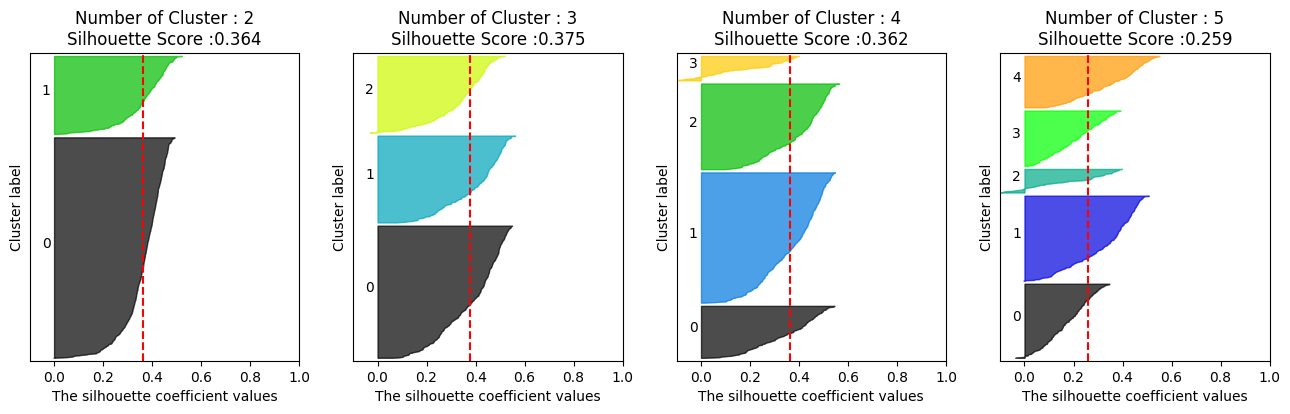

In [296]:
visualize_silhouette([ 2, 3, 4, 5 ], testDF)

실루엣 결과 : clustering 3으로 두는 것이 가장 좋음.

In [277]:
kmeans.fit(testDF)

KMeans(n_clusters=3, random_state=0)

In [278]:
print(kmeans.labels_)

[0 2 1 0 0 1 2 1 1 0 1 1 1 0 0 2 1 0 1 2 2 0 1 0 1 2 2 2 1 1 0 0 2 2 1 0 2
 1 0 0 0 1 0 0 0 0 1 0 1 1 1 2 2 0 2 1 0 0 0 0 2 1 2 0 2 1 1 1 1 2 2 2 1 2
 0 2 1 0 0 0 2 1 0 2 1 2 1 1 0 2 0 0 2 2 2 1 1 0 0 0 2 1 1 2 0 2 2 1 0 0 2
 0 1 1 2 0 2 0 2 1 0 2 0 2 1 1 0 0 0 2 0 2 2 2 1 1 1 0 0 1 2 0 1 1 1 0 0 1
 0 0 1 0 2 2 0 0 2 1 0 2 0 1 0 0 0 0 0 0 1 2 1 1 1 2 0 1 2 0 1 2 0 2 2 0 2
 2 0 1 1 0 0 0 0 1 0 2 0 0 1 1 0 1 0 2 0 2 0 2 2 1 0 1 0 1 1 2 1 2 0 0 0 1
 0 0 0 0 2 2 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 2 0 0 2 0 1 0 0 1 1 2 1 2 1 0 0
 1 0 1 1 0 1 2 1 0 1 1 0 1 0 2 1 0 2 0 1 2 0 2 2 1 1 2 0 0 2 0 2 2 2 0 2 0
 1 2 1 0 0 2 2 1 1 1 0 0 1 1 1 1 2 1 0 0 1 2 1 0 1 2 1 2 0 0 2 0 0 2 0 0 0
 0 2 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 2 1 1 0 0 0 0 1 2 2 0 1 2 0 0 0 1 2 2 2
 0 1 0 2 1 2 1 1 0 1 1 0 0 0 2 0 2 1 2 1 0 2 0 0 2 0 2 0 0 1 0 0 1 0 2 1 2
 0 1 0 0 2 2 2 0 2 0 1 1 0 0 0 0 0 1 0 1 2 1 1 0 2 1 0 0 0 0 0 2 0 2 2 0 2
 0 1 0 0 2 1 0 2 0 0 1 2 0 1 0 1 1 0 1 2 1 1 1 1 0 2 2 0 2 0 1 0 0 0 0 2 0
 1 0 2 0 2 1 0 0 2 0 1 1 

In [286]:
testDF['target'] = test.type
testDF['cluster']=kmeans.labels_
test_result = testDF.groupby(['target','cluster'])['type'].count()
print(test_result)

target  cluster
0       0          442
        1          290
        2            7
1       0            7
        1            2
        2          252
Name: type, dtype: int64


In [287]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(testDF)

testDF['pca_x'] = pca_transformed[:,0]
testDF['pca_y'] = pca_transformed[:,1]
testDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,target,cluster,pca_x,pca_y
0,1.306951,-0.220579,1.098184,0.236865,-0.385503,-1.108531,-0.756734,-0.352060,-1.943080,-1.068114,1.000172,0,0,0,-0.411229,0.174337
1,4.507070,0.477272,1.780836,-0.749722,0.343645,-0.888114,-1.327873,1.915724,-0.949812,-0.311854,-1.203025,1,1,2,3.392725,-2.595502
2,-0.553583,-0.395042,-0.335387,-0.057012,-0.466520,0.709907,1.077835,-0.008456,-0.142782,1.063164,-0.864071,0,0,1,-0.797864,-0.622260
3,-0.032634,-1.151046,0.483796,-0.770714,-0.385503,-0.557489,0.731690,-0.008456,1.905833,-0.449356,-0.355641,0,0,0,-0.741546,0.721138
4,-0.330319,-0.511350,-0.403653,-0.728731,-1.033635,-0.419728,-0.774041,-1.516876,-0.329020,-0.449356,1.169649,0,0,0,-0.935791,2.324264


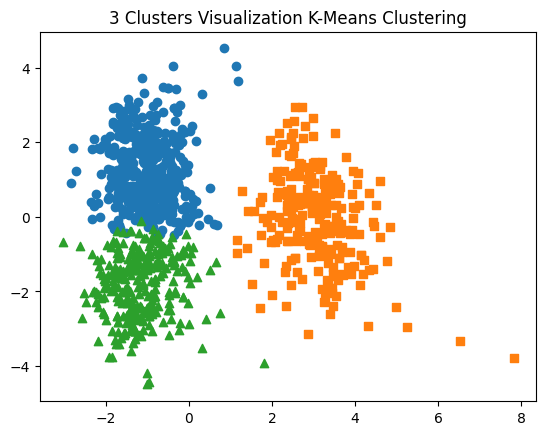

In [299]:
# cluster 값이 0, 1, 2 인 경우마다 별도의 Index로 추출
marker0_ind = testDF[testDF['cluster']==0].index
marker1_ind = testDF[testDF['cluster']==1].index
marker2_ind = testDF[testDF['cluster']==2].index

# cluster값 0, 1, 2에 해당하는 Index로 각 cluster 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 marker 표시
plt.scatter(x=testDF.loc[marker0_ind,'pca_x'], y=testDF.loc[marker0_ind,'pca_y'], marker='o')
plt.scatter(x=testDF.loc[marker1_ind,'pca_x'], y=testDF.loc[marker1_ind,'pca_y'], marker='s')
plt.scatter(x=testDF.loc[marker2_ind,'pca_x'], y=testDF.loc[marker2_ind,'pca_y'], marker='^')

plt.title('3 Clusters Visualization K-Means Clustering')
plt.show()